<a href="https://colab.research.google.com/github/DerekGloudemans/segmentation-medical-images/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

import ipywidgets
import traitlets
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
import torchvision.transforms.functional as FT
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import nibabel as nib



     |████████████████████████████████| 112kB 4.9MB/s 


In [0]:
def track_segment(data,pred,model):
  "Note that pred must be integer, 0 or 1"

  num_slices = data.shape[2]
  result = torch.zeros(data.shape)

  for idx in range(num_slices):
    # resize to 256 x 256
    slice = data[:,:,idx]
    
    # get slice of 
    if idx == 0:
      prev_slice = torch.zeros(slice.shape)
    else:
      prev_slice = pred[:,:,idx-1]

    original_shape = slice.shape

    slice =  Image.fromarray(slice.data.numpy()).copy()
    slice = FT.to_grayscale(slice)
    slice = FT.to_tensor(slice)
    slice = slice.unsqueeze(0)
    prev_slice = prev_slice.unsqueeze(0).unsqueeze(0)

    slice = F.interpolate(slice,size = [256,256],mode = 'bilinear')
    prev_slice = F.interpolate(prev_slice, size = [256,256],mode = 'nearest')

    x = torch.cat((prev_slice,slice),dim = 1)
    x = x.to(device).float()

    out_slice = model(x)
    out_slice = F.interpolate(out_slice,original_shape,mode = 'nearest')
    result[:,:,idx] = out_slice.data.cpu()

    if False:
      plt.figure(figsize = (5,15))
      plt.subplot(132)
      plt.imshow(prev_slice[0][0],cmap = "gray")
      plt.clim(0,1)
      plt.subplot(131)
      plt.imshow(slice[0][0],cmap = "gray")
      plt.clim(0,1)
      plt.subplot(133)
      plt.imshow(result[:,:,idx],cmap = "gray")
      plt.clim(0,1)
      plt.show()

  return result

In [0]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=1,
        depth=3,
        wf=4,
        padding=True,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        innum = 1000
        midnum = 100
        outnum = 4*n_classes
        self.reg = nn.Sequential(
            nn.BatchNorm1d(innum),
            nn.Linear(innum,midnum),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(midnum,outnum),
            nn.Sigmoid()
        )

        #for param in self.parameters():
        #  param.requires_grad = True

    def forward(self, x,BBOX = False):
        blocks = []
        
        # encoder
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        # do bbox regression here
        if BBOX:
          x_reg = x.view(-1)
          x_reg = self.reg(x_reg)
          bboxes = x_reg.view(4,-1)

        # decoder
        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        #CHANGE THIS LINE FOR MULTIPLE OUTPUT CHANNELS
        # apply per_class last layer and per-class Softmax 
        #x = nn.Softmax2d(self.last(x)) 
        x = torch.sigmoid(self.last(x))
        
        if BBOX:
          return x, bboxes
        else:
          return x


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


class UNet2(nn.Module):
    def __init__(
        self,
        in_channels=2,
        n_classes=1,
        depth=3,
        wf=4,
        padding=True,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet2, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        innum = 1000
        midnum = 100
        outnum = 4*n_classes
        self.reg = nn.Sequential(
            nn.BatchNorm1d(innum),
            nn.Linear(innum,midnum),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(midnum,outnum),
            nn.Sigmoid()
        )

        #for param in self.parameters():
        #  param.requires_grad = True

    def forward(self, x,BBOX = False):
        blocks = []
        
        # encoder
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        # do bbox regression here
        if BBOX:
          x_reg = x.view(-1)
          x_reg = self.reg(x_reg)
          bboxes = x_reg.view(4,-1)

        # decoder
        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        #CHANGE THIS LINE FOR MULTIPLE OUTPUT CHANNELS
        # apply per_class last layer and per-class Softmax 
        #x = nn.Softmax2d(self.last(x)) 
        x = torch.sigmoid(self.last(x))
        
        if BBOX:
          return x, bboxes
        else:
          return x


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

class Nifti_Dataset(data.Dataset):
  def __init__(self,mode = "view",dim = 2,class_id = 1):
    """
    Save the last 0.15 proportion of files after sorting for use as validation set.
    Loads each slice of the input images as a separate image
    mode - view,train or val, defined in same dataset to maintain data separation
      view - performs transforms but does not normalize images
      train - normalizes data and performs transforms
      val - normalizes data, no augmenting transforms
    dim - specifies dimension along which to slice image
    """

    self.mode = mode
    self.dim = dim
    self.class_id = class_id

    data_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/img"
    label_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/label"

    # get all data and label file names
    self.data_files = []
    for file in os.listdir(data_dir):
      self.data_files.append(os.path.join(data_dir,file))
    self.data_files.sort()

    self.label_files = []
    for file in os.listdir(label_dir):
      self.label_files.append(os.path.join(label_dir,file))
    self.label_files.sort()

    # for each data_file
    self.train_data = []
    self.val_data = []

    for i in range(len(self.data_files)):
      data = nib.load(self.data_files[i])
      data = np.array(data.get_fdata())

      label = nib.load(self.label_files[i])
      label = np.array(label.get_fdata()).astype(float)

      identifier = self.data_files[i].split("_")[0]
      for slice in range(0,data.shape[dim]):

        # get slices
        if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
        elif dim == 1:
          data_slice = data[:,slice,:]
          label_slice = label[:,slice,:]
        elif dim == 2:
          data_slice = data[:,:,slice]
          label_slice = label[:,:,slice]

        mean,std = np.mean(data_slice),np.std(data_slice)
        # define item dict to store info
        item = {
            "identifier":identifier,
            "slice":slice,
            "data":data_slice,
            "label":label_slice,
            "mean":mean,
            "std":std
            }

        # check to make sure this example actually has organs in it
        test = np.bincount(label_slice.astype(int).reshape(-1))
        if len(test) == 1: 
          continue

        # make sure 50% of examples have organ of interest in them
        if class_id not in np.unique(label_slice.astype(int).reshape(-1)):
            if np.random.rand() > 0.5:
              continue

        # assign to either training or validation data
        if i < len(self.data_files) * 0.85:
          self.train_data.append(item)
        else:
          self.val_data.append(item)

      #break # to shorten loading time

    # define some transforms for training dataset
    self.train_transforms = transforms.Compose([
          transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(p=0.0015, scale=(0.4, 0.6), ratio=(0.3, 3.3), value=0, inplace=False), # big
          transforms.RandomErasing(p=0.003, scale=(0.1, 0.3), ratio=(0.3, 3.3), value=0, inplace=False), # medium
          transforms.RandomErasing(p=0.004, scale=(0.05, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),# small
          transforms.RandomErasing(p=0.0035, scale=(0.05, 0.2), ratio=(0.3, 3.3), value=0, inplace=False) # small
          

        ])

  def __getitem__(self,index):
      #get relevant dictionary from self memory

      if self.mode in ['train','view']:
        item = self.train_data[index]
      else:
        item = self.val_data[index]

      x = Image.fromarray(item['data']).copy()
      y = Image.fromarray(item['label']).copy()

      # to grayscale
      x  = FT.to_grayscale(x)
      y = FT.to_grayscale(y)

      if self.mode in ['train','view']:
        # randomly flip and rotate both
        FLIP = 0 #np.random.rand()
        if FLIP > 0.5:
          x = FT.hflip(x)
          y = FT.hflip(y)

        ROTATE = 0 #np.random.rand()*60 - 30
        x  = x.rotate(ROTATE)
        y = y.rotate(ROTATE,Image.NEAREST)

      # resize to 224 on shorter dimension
      x = FT.resize(x, 256)
      y = FT.resize(y,256,Image.NEAREST)

      if self.mode in ['train','view']:
        # randomly jitter color of data and randomly erase data
        x = self.train_transforms(x)
      # to tensor
      try:
        x = FT.to_tensor(x)
      except:
        pass
      y = FT.to_tensor(y)
            
      # normalize and repeat along color dimension if in train or val mode
      if self.mode in ['train','val']:
        #x = FT.normalize(x,[item['mean']],[item['std']])
        #x = x.repeat(3,1,1)
        pass

      return x,y

  def __len__(self):
    if self.mode in ["train","view"]:
      return len(self.train_data)
    else:
      return len(self.val_data)

  def show(self,index):
    data,label = self[index]
    plt.figure()
    plt.subplot(121)
    data = data.detach()
    plt.imshow(data[0],cmap = "gray")

    plt.subplot(122)
    plt.imshow(label[0],cmap = "gray")
    plt.show()
    # convert each tensor to numpy array

  def show_slices(self,idx = 0,dim = 0,organ_id = None):
    """
    A nice utility function for plotting all of the slices along a given dimension
    idx - indexes all NIfTI images in dataset
    dim - indexes dimension of image
    organ_id - if not None, all other organs removed from label
    """
    data = nib.load(self.data_files[idx])
    label = nib.load(self.label_files[idx])

    data = data.get_fdata()
    data = np.array(data)
    label = label.get_fdata()
    label = np.array(label)

    for slice in range(0,data.shape[dim]):
      if dim == 0:
            data_slice = data[slice,:,:]
            label_slice = label[slice,:,:]
      elif dim == 1:
        data_slice = data[:,slice,:]
        label_slice = label[:,slice,:]
      elif dim == 2:
        data_slice = data[:,:,slice]
        label_slice = label[:,:,slice]

      if organ_id is not None:
        # if a specific label is to be looked at, 0 all others
        label_slice = 1.0 - np.ceil(np.abs(label_slice.astype(float)-organ_id)/15.0)

      print(np.unique(label_slice))
      plt.figure()
      plt.subplot(121)
      plt.imshow(data_slice,cmap = "gray")

      plt.subplot(122)
      plt.imshow(label_slice,cmap = "gray")
      plt.show()

  def len_3d(self):
    return len(self.data_files)

  def get_3d_array(self,idx):
      """
      Loads a 3D image as a tensor as well as its label, mode, and file name
      """
      assert idx < len(self.data_files) , "3D image index out of range, there are {} 3D images".format(len(self.data_files))

      # load data and label as tensors
      data = nib.load(self.data_files[idx])
      label = nib.load(self.label_files[idx])

      data = data.get_fdata()
      data = torch.from_numpy(np.array(data))
      label = label.get_fdata()
      label = torch.from_numpy(np.array(label)).int()

      # note whether image is training or validation set
      if idx < 0.85 * len(self.data_files):
        mode = "train"
      else:
        mode = "val"
      
      return data,label,mode,self.data_files[idx]

def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

  return model,optimizer,epoch,all_losses,all_accs


def dt_refine(orig,tree):
  """
  Applies decision tree ensembling to original outputs
  orig = classes x l x w x h
  """
  output = torch.zeros((orig.shape[1],orig.shape[2],orig.shape[3]))

  for i in range(0,orig.shape[1]):
    for j in range(0,orig.shape[2]):
      
        inp = np.zeros([orig.shape[3],17])
        inp[:,:14] = orig[:,i,j,:].data.numpy().transpose()
        inp[:,14] = i
        inp[:,15] = j
        for k in range(0,orig.shape[3]):
          inp[k,16] = k

        output[i,j,:] = torch.from_numpy(tree.predict(inp))
  
  return output


def segment(model,data,device,axis = 2,outfile = None):
  """
  Takes in 3D tensor, slices and segments using UNET, and returns result
  Note that result will be a [0,1] tensor corresponding to a certain class (whatever model class was used)
  if outfile is not none, saves results in  that file 
  """

  num_slices = data.shape[axis]
  result = torch.zeros(data.shape)

  for idx in range(num_slices):
    # resize to 256 x 256
    if axis == 0:
      slice = data[idx,:,:]
    elif axis == 1:
      slice = data[:,idx,:]
    elif axis == 2:
      slice = data[:,:,idx]

    original_shape = slice.shape

    slice =  Image.fromarray(slice.data.numpy()).copy()
    slice = FT.to_grayscale(slice)
    slice = FT.to_tensor(slice)
    slice = slice.unsqueeze(0)

    slice = F.interpolate(slice,size = [256,256],mode = 'bilinear')

    x = slice.to(device).float()

    out_slice = model(x)
    out_slice = F.interpolate(out_slice,original_shape,mode = 'bilinear')

    if axis == 0:
      result[idx,:,:] = out_slice.data.cpu()
    elif axis == 1:
      result[:,idx,:] = out_slice.data.cpu()
    elif axis == 2:
      result[:,:,idx] = out_slice.data.cpu()

  if outfile:
    torch.save(result, outfile)

  return result

#def segment(model,checkpoint_dict,data,device,outfile = None):
#  """
#  Takes a 3D tensor and segments it with a series of models, predicting maximum class for each
#  """
#  result = torch.zeros((data.shape[0],data.shape[1],data.shape[2]))
#  result = predict_by_slices(model,data,device,outfile = None)
#  return result


def dice_3D(output,target,threshold= 0.5,eps=1e-07):
    ones = torch.ones(target.shape)
    zeros = torch.zeros(target.shape)
    true_pos = torch.where(target == 1,ones,zeros)
    pred_pos = torch.where(output > threshold,ones,zeros)

    numerator = 2.0 * torch.mul(true_pos,pred_pos) + eps
    denominator = true_pos + pred_pos + eps

    dice = (numerator.sum())/denominator.sum()
    return dice


In [0]:
def thresh_plot(data,step = 0.02):
  plt.figure(figsize = (10,15))
  from matplotlib import style
  style.use("fivethirtyeight")

  x = np.arange(0,1,step)
  legend = []
  for key in data:
    series = data[key]
    plt.plot(x,series)
    legend.append(key)
  
  plt.xlabel("Discrimination Threshold")
  plt.ylabel("Dice Accuracy")
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.title("Discrimination Threshold Accuracy for Various Pooling Sizes")
  plt.legend(legend)
  plt.show()

# Load everything up

In [0]:
checkpoint_dict = {
    "dim0":"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/organ1_dim0_e22.pt",
    "dim1":"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/organ1_dim1_e15.pt",
    "dim2":"/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/Keepers/Final/organ1_dim2_e120.pt"
}

In [0]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.empty_cache()   

model = UNet()
print ("Model loaded.")
model = model.to(device)
model.eval()

checkpoint = torch.load(checkpoint_dict['dim1'])
model.load_state_dict(checkpoint['model_state_dict'])

try:
  dataset
except:
  dataset = Nifti_Dataset(mode = "train",dim = 2)

Model loaded.


# Generate Baseline Results for Each Dimension
This means slicing each input file up and segmenting each slice. All outputs for the entire regime will be binary (for spleen only)

## Dimension 0

In [0]:
_inputs = []            # list of raw input files (3D)
_baseline_outputs0 = []   # list of baseline output files (3D)
_targets = []           # list of targets (3D)
baseline_results0 = []   # list of baseline dice scores (1D)

checkpoint = torch.load(checkpoint_dict["dim0"])
model.load_state_dict(checkpoint['model_state_dict'])

for idx in range(24,dataset.len_3d()):
    x,y,mode,name = dataset.get_3d_array(idx)
    
    if mode == "train":
      continue

    elif mode == "val":
      print("Processing file {}".format(idx))
      _inputs.append(x)
      _targets.append(y)
      
      result = segment(model,x,device,axis = 0)
      _baseline_outputs0.append(result)
      baseline_results0.append(dice_3D(result,y))

accuracy = sum(baseline_results0)/len(baseline_results0)
print ("Baseline accuracy: {}".format(accuracy))

Processing file 26


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Processing file 27
Processing file 28
Processing file 29
Baseline accuracy: 0.6429153084754944


In [0]:
if False:
  pool_size = [5,7,9,11]

  __pool_results = {
      5:[],
      7:[],
      9:[],
      11:[],
      13:[]
  }

  all_thresh_plots = {}


  for p in pool_size:
    
      for i in range(len(_baseline_outputs0)):
        result = _baseline_outputs0[i]
        __pool_results[p].append(F.avg_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0))
      
      threshold_results = []
      for threshold in np.arange(0,1,0.02):
        running_score = 0
        for i in range(len(__pool_results[p])):
          result = __pool_results[p][i]
          running_score += dice_3D(result,_targets[i],threshold = threshold)
        running_score = running_score/len(__pool_results[p])
        threshold_results.append(running_score)
      
      #plot
      print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
      all_thresh_plots[p] =  threshold_results

  thresh_plot(all_thresh_plots,step = 0.02)
  __pool_results0 = __pool_results.copy()

## Dimension 1

In [0]:
_baseline_outputs1 = []   # list of baseline output files (3D)
baseline_results1 = []   # list of baseline dice scores (1D)

checkpoint = torch.load(checkpoint_dict["dim1"])
model.load_state_dict(checkpoint['model_state_dict'])

for idx in range(24,dataset.len_3d()):
    x,y,mode,name = dataset.get_3d_array(idx)
    
    if mode == "train":
      continue

    elif mode == "val":
      print("Processing file {}".format(idx))
      
      result = segment(model,x,device,axis = 2)
      _baseline_outputs1.append(result)
      baseline_results1.append(dice_3D(result,y))

accuracy = sum(baseline_results1)/len(baseline_results1)
print ("Baseline accuracy: {}".format(accuracy))

Processing file 26


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Processing file 27
Processing file 28
Processing file 29
Baseline accuracy: 0.3808141350746155


In [0]:
if False:
  pool_size = [5,7,9,11]

  __pool_results = {
      5:[],
      7:[],
      9:[],
      11:[],
      13:[]
  }

  all_thresh_plots = {}


  for p in pool_size:
    
      for i in range(len(_baseline_outputs1)):
        result = _baseline_outputs1[i]
        __pool_results[p].append(F.avg_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0))
      
      threshold_results = []
      for threshold in np.arange(0,1,0.02):
        running_score = 0
        for i in range(len(__pool_results[p])):
          result = __pool_results[p][i]
          running_score += dice_3D(result,_targets[i],threshold = threshold)
        running_score = running_score/len(__pool_results[p])
        threshold_results.append(running_score)
      
      #plot
      print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
      all_thresh_plots[p] =  threshold_results

  thresh_plot(all_thresh_plots,step = 0.02)
  __pool_results1 = __pool_results.copy()

## Dimension 2

In [0]:
_baseline_outputs2 = []   # list of baseline output files (3D)
baseline_results2 = []   # list of baseline dice scores (1D)

checkpoint = torch.load(checkpoint_dict["dim2"])
model.load_state_dict(checkpoint['model_state_dict'])

for idx in range(24,dataset.len_3d()):
    x,y,mode,name = dataset.get_3d_array(idx)
    
    if mode == "train":
      continue

    elif mode == "val":
      print("Processing file {}".format(idx))
      _inputs.append(x)
      _targets.append(y)
      
      result = segment(model,x,device,axis = 2)
      _baseline_outputs2.append(result)
      baseline_results2.append(dice_3D(result,y))

accuracy = sum(baseline_results2)/len(baseline_results2)
print ("Baseline accuracy: {}".format(accuracy))

Processing file 26


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Processing file 27
Processing file 28
Processing file 29
Baseline accuracy: 0.6108388900756836


Best accuracy for pooling size 1: 0.8787376880645752
Best accuracy for pooling size 3: 0.8789782524108887
Best accuracy for pooling size 5: 0.8793649673461914
Best accuracy for pooling size 7: 0.8784712553024292


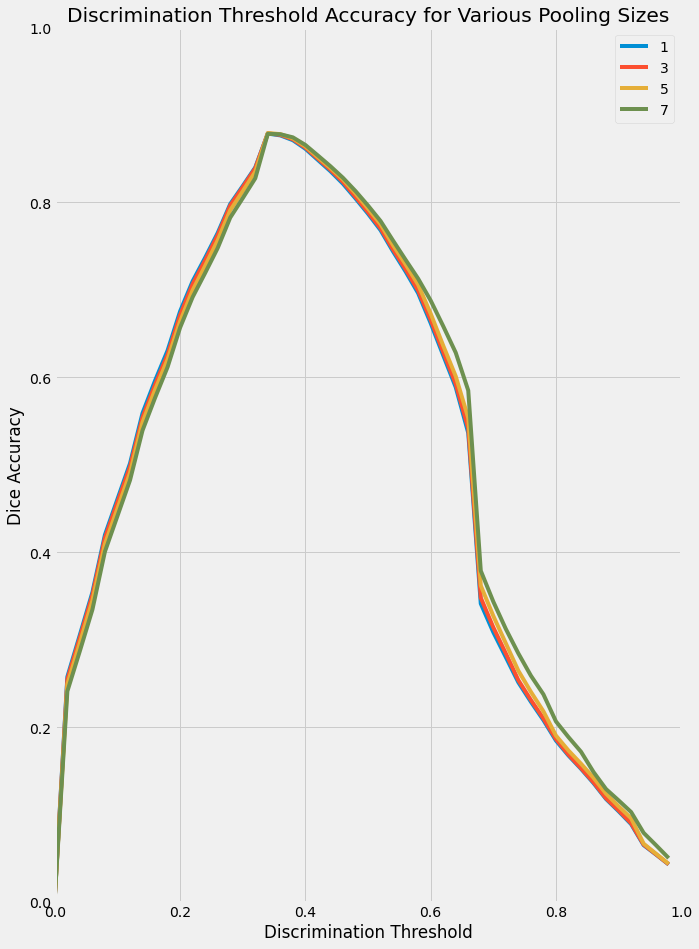

In [0]:
if True:
  pool_size = [1,3,5,7]

  avgpool_results = {
      1:[],
      3:[],
      5:[],
      7:[],
      9:[],
      11:[],
      13:[]
  }

  all_thresh_plots = {}


  for p in pool_size:
    
      for i in range(len(_baseline_outputs2)):
        result = _baseline_outputs2[i]
        avgpool_results[p].append(F.avg_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0))
      
      threshold_results = []
      for threshold in np.arange(0,1,0.02):
        running_score = 0
        for i in range(len( avgpool_results[p])):
          result = __pool_results[p][i]
          running_score += dice_3D(result,_targets[i],threshold = threshold)
        running_score = running_score/len( avgpool_results[p])
        threshold_results.append(running_score)
      
      #plot
      print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
      all_thresh_plots[p] =  threshold_results

  thresh_plot(all_thresh_plots,step = 0.02)


In [0]:
del dataset  # won't need any more, but be careful so you don't have to load it again

# Combine results from all 3 Dimensions
Each of the following strategies will be explored
- Combine, DT
- Combine, avgpool (5,7,9,11) DT
- avgpool (5,7,9,11), combine, DT
- avgpool (5,7,9,11), combine, avgpool (3,5,7), DT

## Combine and Threshold


Best accuracy for weighting [0.4, 0.2, 0.4] : 0.8577910661697388


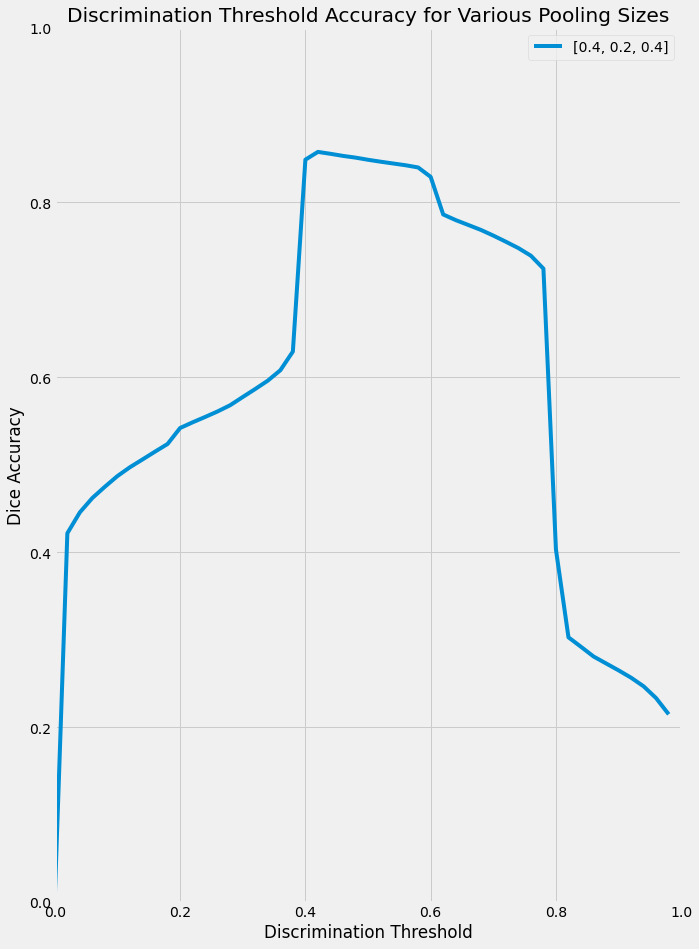

In [0]:
if True:
  all_thresh_plots = {}
  _weighted_combo_results = []

  for weighting in [[0.4,0.2,0.4]]:
    _weighted_combo_results = []

    for i in range(len(_baseline_outputs0)):
        result0 = _baseline_outputs0[i]
        result1 = _baseline_outputs1[i]
        result2 = _baseline_outputs2[i]
        result = result0*weighting[0] + result1*weighting[1] + result2*weighting[2]
        _weighted_combo_results.append(result)

    threshold_results = []
    for threshold in np.arange(0,1,0.02):
      running_score = 0
      for i in range(len(_weighted_combo_results)):
        result = _weighted_combo_results[i]
        running_score += dice_3D(result,_targets[i],threshold = threshold)
      running_score = running_score/len(_weighted_combo_results)
      threshold_results.append(running_score)
    
    #plot
    print("Best accuracy for weighting {} : {}".format(weighting,max(threshold_results)))
    all_thresh_plots[str(weighting)] =  threshold_results

  thresh_plot(all_thresh_plots,step = 0.02)

## Combine, AvgPool, and Threshold

Best accuracy for pooling size 1: 0.8577910661697388
Best accuracy for pooling size 3: 0.8799988031387329
Best accuracy for pooling size 5: 0.8785765767097473
Best accuracy for pooling size 7: 0.8664190769195557


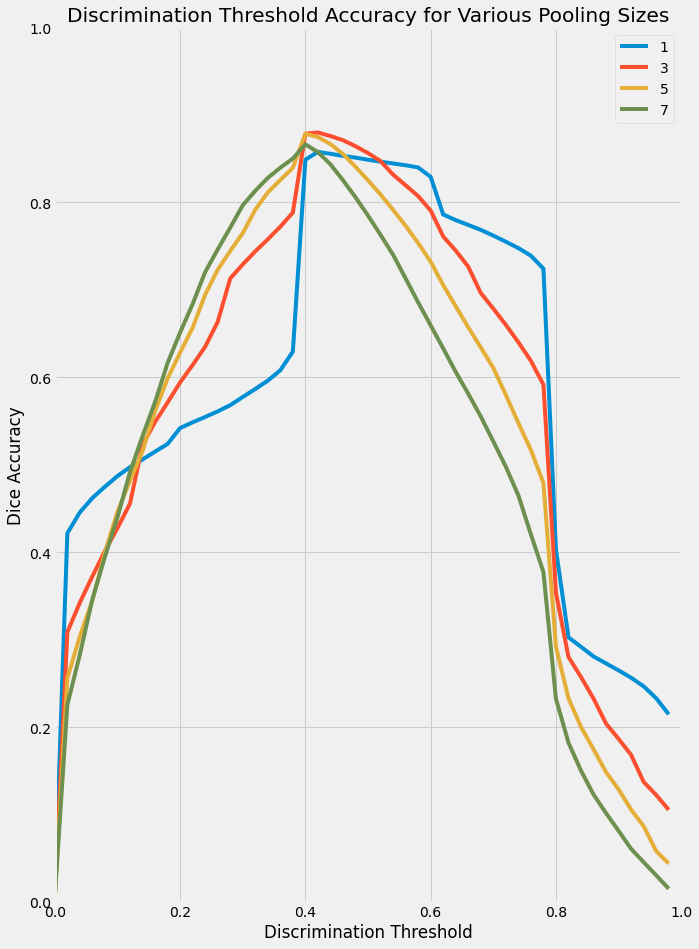

In [0]:
if True:
  pool_size = [1,3,5,7]

  __pool_results = {
      1:[],
      3:[],
      5:[],
      7:[],
      9:[]
  }

  all_thresh_plots = {}
  _weighted_combo_results = []
  weighting = [0.4,0.2,0.4]

  # generate combo results
  for i in range(len(_baseline_outputs0)):
    result0 = _baseline_outputs0[i]
    result1 = _baseline_outputs1[i]
    result2 = _baseline_outputs2[i]
    result = result0*weighting[0] + result1*weighting[1] + result2*weighting[2]
    _weighted_combo_results.append(result)

  for p in pool_size:
    
      for i in range(len(_baseline_outputs2)):
        result = _weighted_combo_results[i]
        __pool_results[p].append(F.avg_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0))
      
      threshold_results = []
      for threshold in np.arange(0,1,0.02):
        running_score = 0
        for i in range(len(__pool_results[p])):
          result = __pool_results[p][i]
          running_score += dice_3D(result,_targets[i],threshold = threshold)
        running_score = running_score/len(__pool_results[p])
        threshold_results.append(running_score)
      
      #plot
      print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
      all_thresh_plots[p] =  threshold_results

  thresh_plot(all_thresh_plots,step = 0.02)

In [0]:
avg5_results = __pool_results[5]

def find_hull(volume):
  points = volume.nonzero()
  hull = ConvexHull(points,incremental = True)
  hull_points = points[hull.vertices]
  if not isinstance(hull,Delaunay):
      hull = Delaunay(hull_points)
      vertices = hull.vertices
  minx = torch.min(hull_points[:,0])
  maxx = torch.max(hull_points[:,0])
  miny = torch.min(hull_points[:,1])
  maxy = torch.max(hull_points[:,1])
  minz = torch.min(hull_points[:,2])
  maxz = torch.max(hull_points[:,2])

  all_points = []
  for i in range(minx,maxx):
    for j in range(miny,maxy):
      for k in range(minz,maxz):
        all_points.append(torch.Tensor([i,j,k]).float())
  print(all_points[0].shape)
  all_points = torch.stack(all_points)
  inside = hull.find_simplex(all_points)
  print(min(inside))
  volume[i,j,k] = 1
  
  return volume

In [0]:
#mask_results
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay



def find_hull(volume):
  points = volume.nonzero()
  hull = ConvexHull(points,incremental = True)
  hull_points = points[hull.vertices].long()
  if not isinstance(hull,Delaunay):
      hull = Delaunay(hull_points)
  minx = torch.min(hull_points[:,0])
  maxx = torch.max(hull_points[:,0])
  miny = torch.min(hull_points[:,1])
  maxy = torch.max(hull_points[:,1])
  minz = torch.min(hull_points[:,2])
  maxz = torch.max(hull_points[:,2])

  for i in range(minx,maxx):
    print(i)
    for j in range(miny,maxy):
      for k in range(minz,maxz):
          new_point = torch.Tensor([i,j,k]).unsqueeze(0).long()
          new_points = torch.cat((hull_points,new_point),0)
          new_hull = ConvexHull(new_points,incremental = True)
          new_hull_points = new_points[new_hull.vertices]

          if new_hull_points.sum() == hull_points.sum():
            volume[i,j,k] = 1
  
  return volume

hulled = find_hull(mask_results[0])

In [0]:
pool_size = [1,3,5,7]

mask_pool_results = {
    1:[],
    3:[],
    5:[],
    7:[],
    9:[]
}

all_thresh_plots = {}
weighting = [0.4,0.2,0.4]

for p in pool_size:
  
    for i in range(len(mask_results)):
      result = mask_results[i]
      result = F.avg_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0)
      mask_pool_results[p].append(result)
    
    threshold_results = []
    for threshold in np.arange(0,1,0.02):
      running_score = 0
      for i in range(1, len(mask_pool_results[p])):
        result = mask_pool_results[p][i]
        running_score += dice_3D(result,_targets[i],threshold = threshold)
      running_score = running_score/len(mask_pool_results[p])
      threshold_results.append(running_score)
    
    #plot
    print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
    all_thresh_plots[p] =  threshold_results

thresh_plot(all_thresh_plots,step = 0.02)

Best accuracy for pooling size 1: 0.6920743584632874
Best accuracy for pooling size 3: 0.6939620971679688


In [0]:
volume = mask_results[1]
p = 9
avg = F.avg_pool3d(volume.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0)

diff = avg - volume

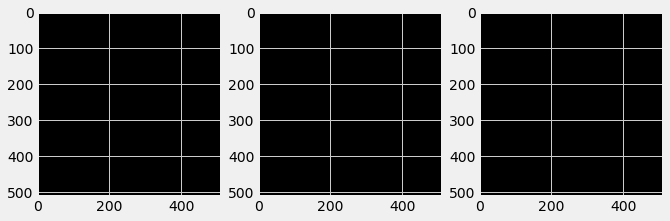

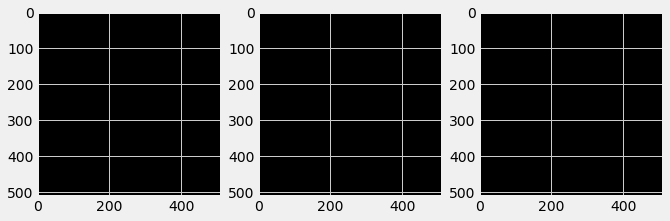

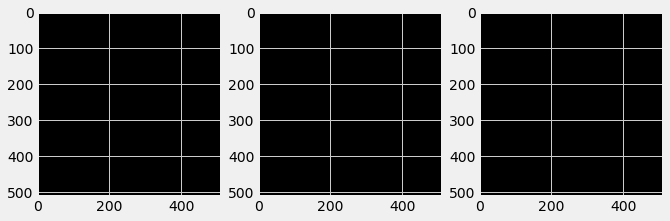

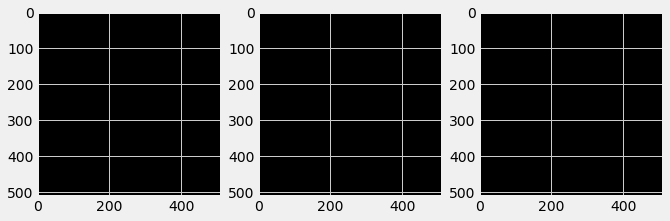

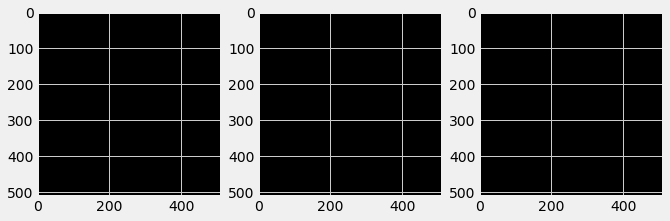

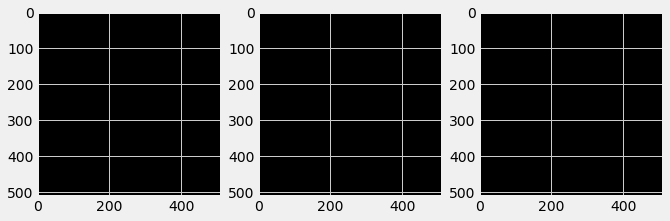

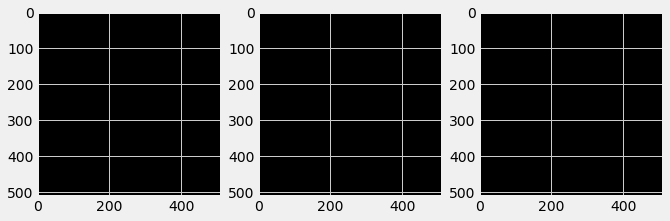

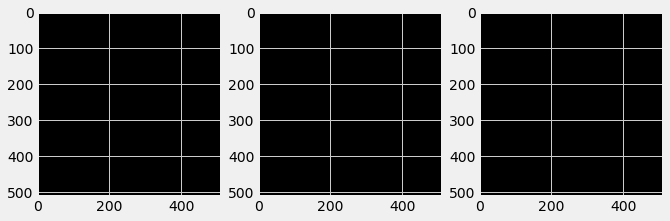

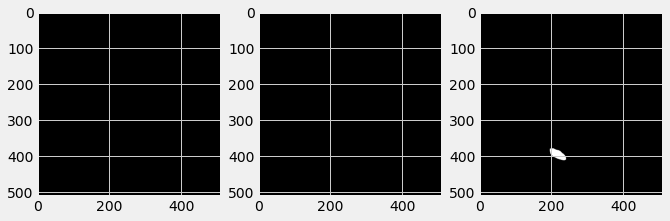

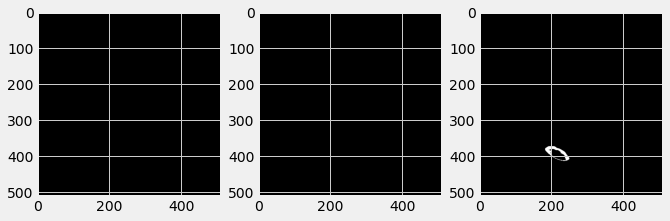

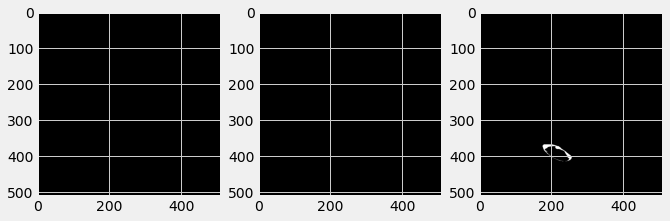

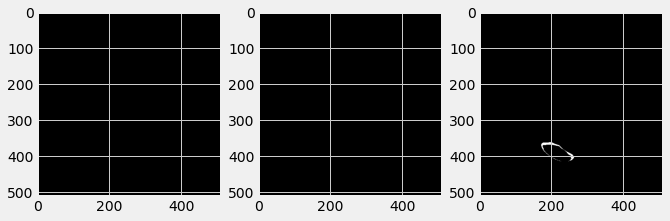

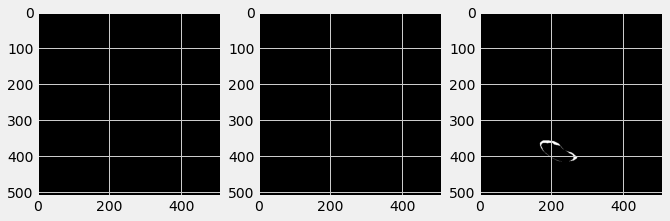

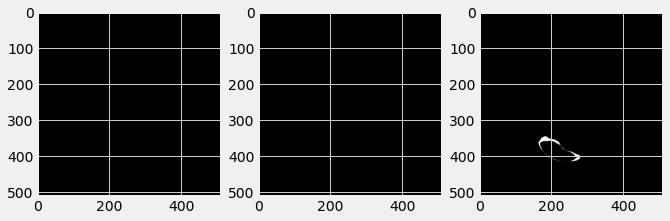

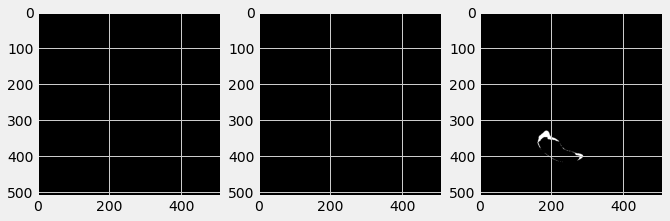

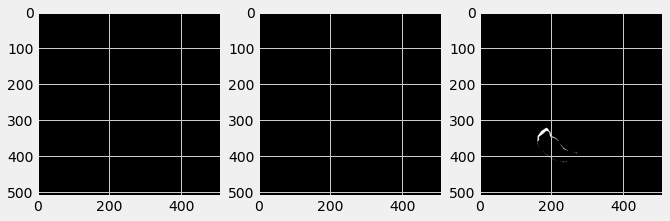

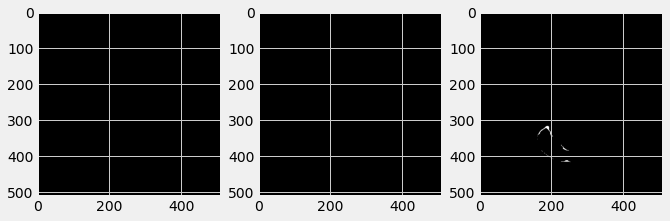

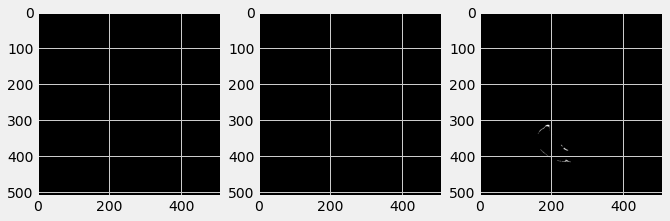

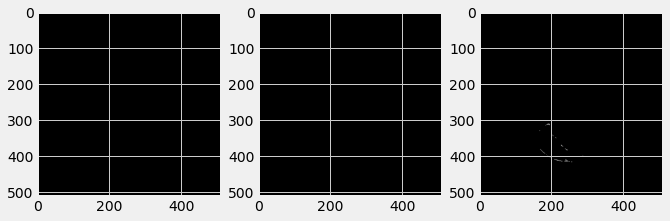

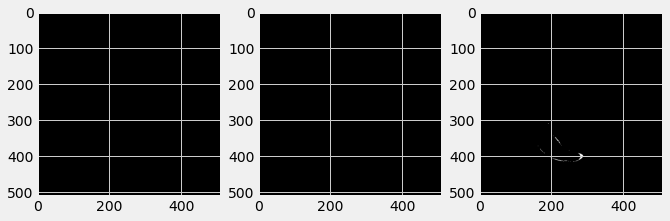

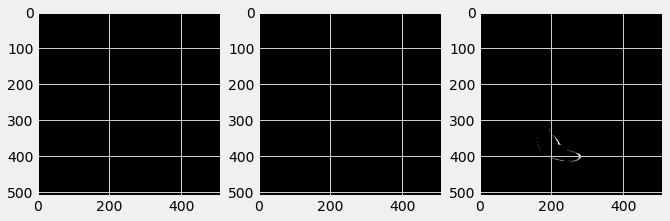

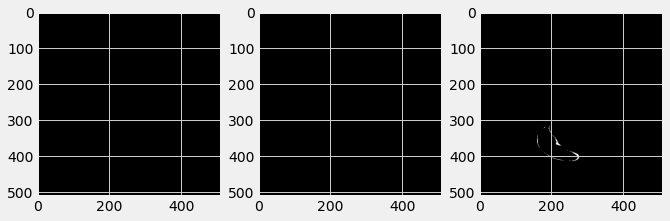

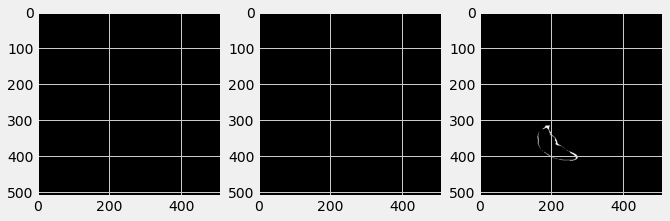

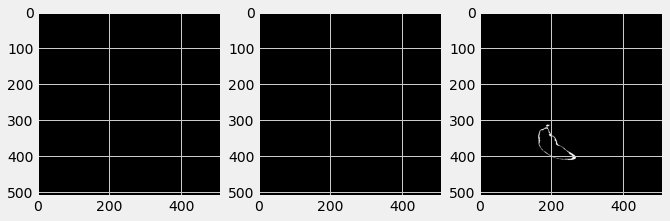

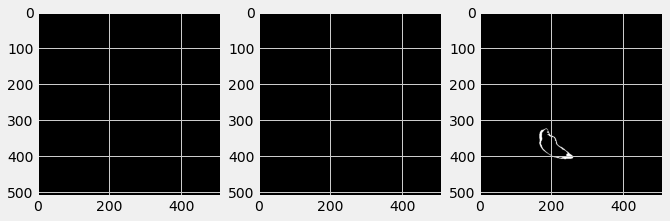

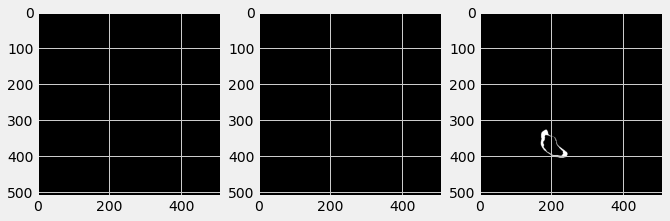

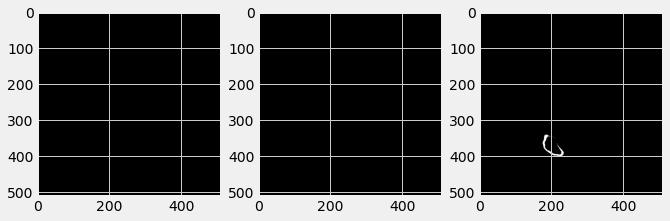

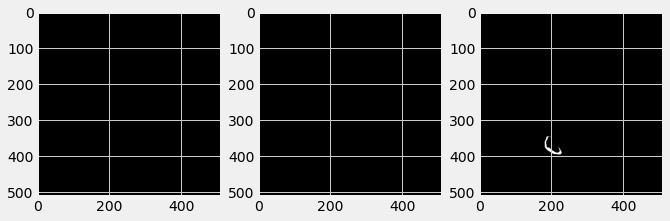

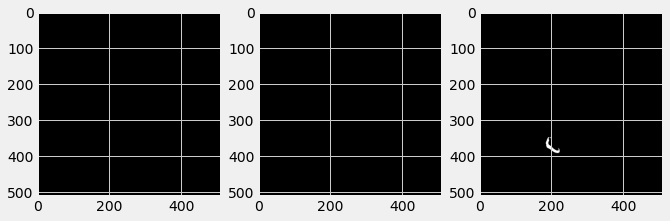

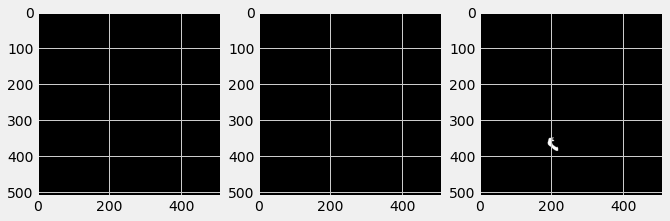

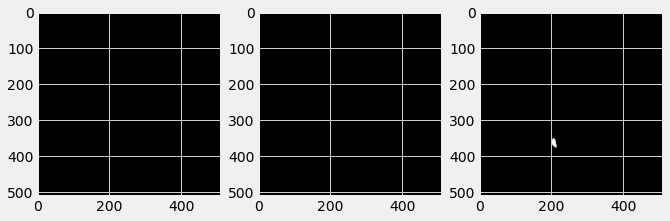

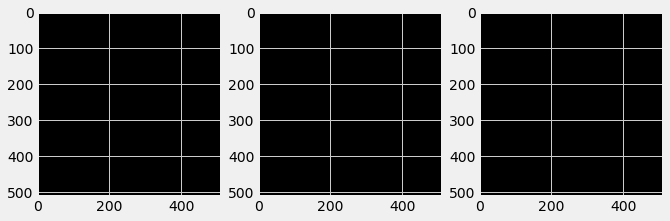

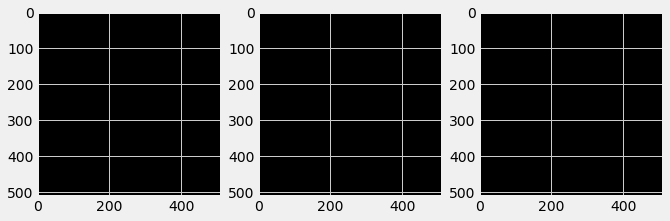

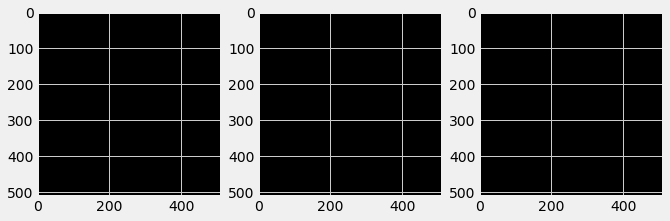

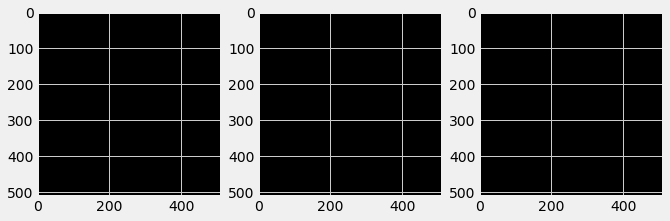

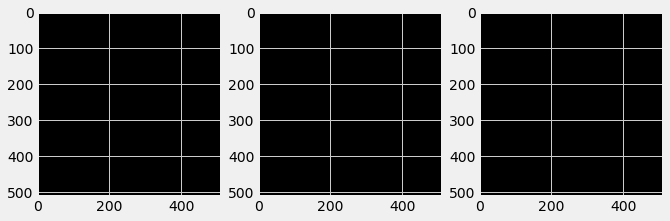

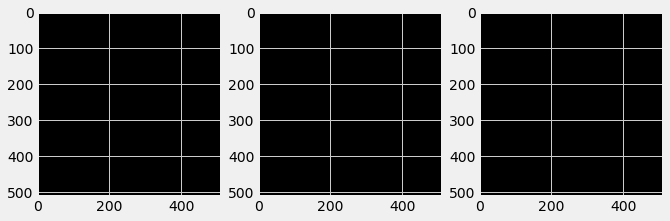

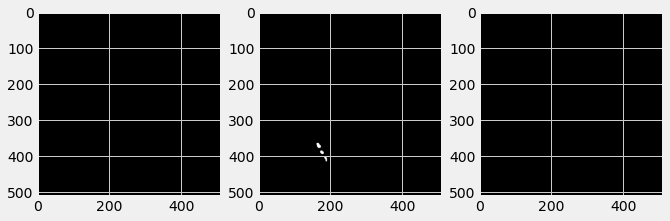

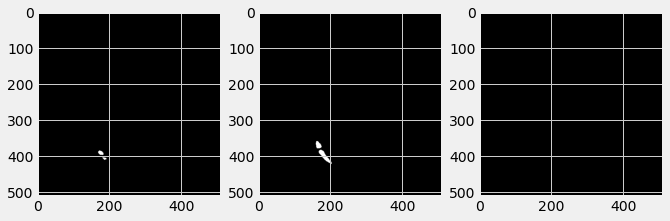

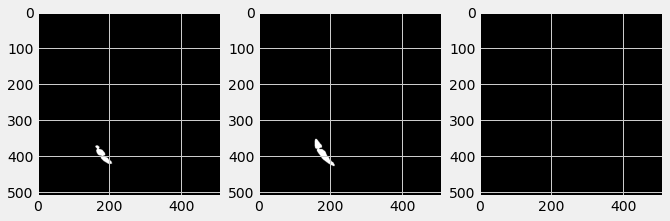

IndexError: ignored

In [0]:
vol_num = 3
volume = mask_results[vol_num]
p = 3
max_volume = diff
for idx in range(60,volume.shape[2]):
    slice = volume[:,:,idx]
    ones = torch.ones(slice.shape)
    slice = torch.where(slice > 0.48,ones,1-ones)
    
    target_slice = _targets[vol_num][:,:,idx]
    target_slice = torch.where(target_slice == 1, ones, 1-ones)

    max_slice = max_volume[:,:,idx]
    max_slice = torch.where(max_slice > 0.36,ones,1-ones)

    plt.figure(figsize = (10,10))
    plt.subplot(131)
    plt.imshow(slice,cmap = "gray")
    plt.clim(0,1)
    plt.subplot(132)
    plt.imshow(target_slice,cmap = "gray")
    plt.clim(0,1)

    plt.subplot(133)
    plt.imshow(max_slice,cmap = "gray")
    plt.clim(0,1)

    plt.show()
  

In [0]:
# plot the slices so we can see what's going on
if False:
  vol_num = 0
  volume = __pool_results[5][vol_num]

  p = 5
  max_volume = F.max_pool3d(volume.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0)
  max_volume = 1.0 - F.max_pool3d(1.0 - max_volume.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0)

  for idx in range(volume.shape[2]):
    slice = volume[:,:,idx]
    ones = torch.ones(slice.shape)
    slice = torch.where(slice > 0.48,ones,1-ones)
    
    target_slice = _targets[vol_num][:,:,idx]
    target_slice = torch.where(target_slice == 1, ones, 1-ones)

    max_slice = max_volume[:,:,idx]
    max_slice = torch.where(max_slice > 0.36,ones,1-ones)

    plt.figure(figsize = (10,10))
    plt.subplot(131)
    plt.imshow(slice,cmap = "gray")
    plt.clim(0,1)
    plt.subplot(132)
    plt.imshow(target_slice,cmap = "gray")
    plt.clim(0,1)

    plt.subplot(133)
    plt.imshow(max_slice,cmap = "gray")
    plt.clim(0,1)

    plt.show()
  

## Combine Best Avgpooled and Maxpooling Results



In [0]:
if True:
  pool_size = [1,3,5,7]

  __pool_results = {
      1:[],
      3:[],
      5:[],
      7:[],
      9:[],
      11:[]
  }

  all_thresh_plots = {}
  _weighted_combo_results = []
  weighting = [1/3,1/3,1/3]

  # generate combo results
  for i in range(len(_baseline_outputs0)):
    result0 = _baseline_outputs0[i]
    result1 = _baseline_outputs1[i]
    result2 = _baseline_outputs2[i]
    result = result0*weighting[0] + result1*weighting[1] + result2*weighting[2]
    _weighted_combo_results.append(result)

  for p in pool_size:
    
      for i in range(len(_baseline_outputs2)):
        result = _weighted_combo_results[i]
        result = F.avg_pool3d(result.unsqueeze(0),5,stride = 1,padding = int((5-1)/2)).squeeze(0)
        result = F.max_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0)
        result = 1.0 - F.max_pool3d(1.0 - result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0)


        __pool_results[p].append(result)
      
      threshold_results = []
      for threshold in np.arange(0,1,0.02):
        running_score = 0
        for i in range(len(__pool_results[p])):
          result = __pool_results[p][i]
          running_score += dice_3D(result,_targets[i],threshold = threshold)
        running_score = running_score/len(__pool_results[p])
        threshold_results.append(running_score)
      
      #plot
      print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
      all_thresh_plots[p] =  threshold_results

  thresh_plot(all_thresh_plots,step = 0.02)

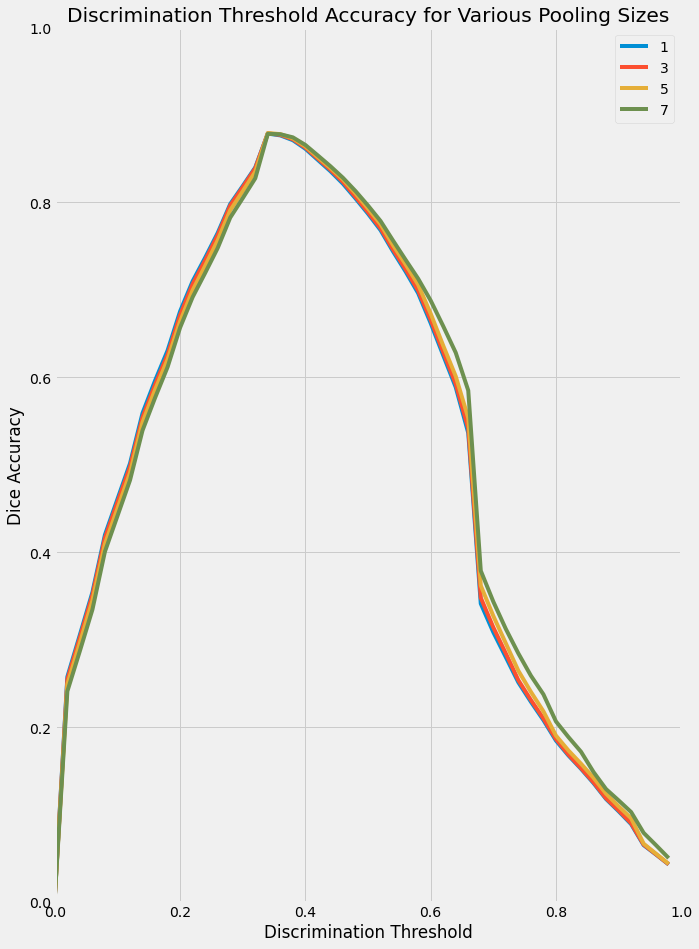

In [0]:
  thresh_plot(all_thresh_plots,step = 0.02)

In [0]:
for key in __pool_results:
  all_results = __pool_results[key]
  running_score = 0

  for i in range(0,len(all_results)):
    result = all_results[i]
    target = _targets[i]

    # threshold
    ones = torch.ones(target.shape)
    result = torch.where(result > 0.36, ones, 1.0 - ones)

    result = reachability_cluster(result)

    dice = dice_3D(result,target,threshold = 0.5)
    running_score += dice 

  running_score = running_score/len(all_results)
  print("Dice score for kernel size {}: {}".format(key,running_score))


Dice score for kernel size 1: 0.8934592604637146
Dice score for kernel size 3: 0.8944089412689209
Dice score for kernel size 5: 0.8956102132797241
Dice score for kernel size 7: 0.8971319198608398


ZeroDivisionError: ignored

In [0]:
def reachability_cluster_mask(input):
  """
  Uses reachability to cluster a 3D tensor of 0,1
  """
  data = input.clone()
  cluster_val = 2
  cluster_sizes = {}

  ones = torch.ones(input.shape)
  zeros = torch.zeros(input.shape)
  original_length = len(torch.where(data == 1, ones, zeros).nonzero())
  queue = []
  contin = True
  while True:
    if cluster_val > 1000:
      break
    cluster_sizes[cluster_val] = 0
    mask = torch.where(data==1,ones,zeros)
    indices = mask.nonzero()

    # if any values in tensor are still 1 continue (unclustered)
    if len(indices) > 1:
      first = indices[0]
      queue.append(first)
    else:
      contin = False
      break

    #print("Assigning cluster {}".format(cluster_val))

    while len(queue) > 0:
      cur = queue.pop(0)
      val = data[cur[0],cur[1],cur[2]]
      if val == 1:
        cluster_sizes[cluster_val] += 1
        data[cur[0],cur[1],cur[2]] = cluster_val # assign to cluster
        # add neighbors to queue
        add_indices = [[cur[0],cur[1],cur[2]+1],
                        [cur[0],cur[1],cur[2]-1],
                        [cur[0],cur[1]+1,cur[2]],
                        [cur[0],cur[1]-1,cur[2]],
                        [cur[0]-1,cur[1],cur[2]],
                        [cur[0]+1,cur[1],cur[2]]]
        if cur[0] < data.shape[0]-1 and cur[1] < data.shape[1]-1 and cur[2] < data.shape[2] - 1:
          for item in add_indices:
            queue.append(item)

    cluster_val += 1
    
  biggest_idx = 2
  biggest_size = 0
  for key in cluster_sizes:
    if cluster_sizes[key] > biggest_size:
      biggest_idx = key
      biggest_size = cluster_sizes[key]
  # get biggest cluster
  mask1 = torch.where((data == biggest_idx), ones, 1.0 - ones)
  mask2 = torch.where((data == 0), ones, 1.0 - ones)
  mask = mask1+mask2
  return mask





In [0]:
if False:
  # plot the slices so we can see what's going on
  vol_num = 0
  volume = __pool_results[5][vol_num]

  ones = torch.ones(volume.shape)
  volume_thresh = torch.where(volume > 0.3, ones,1.0-ones)
  #clustered = reachability_cluster(volume_thresh)

  for idx in range(volume.shape[2]):
    slice = volume[:,:,idx]
    ones = torch.ones(slice.shape)
    slice = torch.where(slice > 0.48,ones,1-ones)
    
    target_slice = _targets[vol_num][:,:,idx]
    target_slice = torch.where(target_slice == 1, ones, 1-ones)

    #cluster_slice = clustered[:,:,idx]

    plt.figure(figsize = (10,10))
    plt.subplot(131)
    plt.imshow(slice,cmap = "gray")
    plt.clim(0,1)

    plt.subplot(133)
    plt.imshow(target_slice,cmap = "gray")
    plt.clim(0,1)

    plt.subplot(132)
    plt.imshow(cluster_slice,cmap = "gray")

    plt.show()

## Combine, Avgpool, threshold, remove anomalous clusters

In [0]:
def thresh_plot(data,step = 0.1):
  plt.figure(figsize = (10,15))
  from matplotlib import style
  style.use("fivethirtyeight")

  x = np.arange(0.1,1,step)
  legend = []
  for key in data:
    series = data[key]
    plt.plot(x,series)
    legend.append(key)
  
  plt.xlabel("Discrimination Threshold")
  plt.ylabel("Dice Accuracy")
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.title("Discrimination Threshold Accuracy for Various Pooling Sizes with Cluster Elimination")
  plt.legend(legend)
  plt.show()

In [0]:
pool_size = [3]

__cluster_results = {
    1:[],
    3:[],
    5:[],
    7:[],
    9:[]
}


all_thresh_plots = {}
_weighted_combo_results = []
weighting = [0.4,0.2,0.4]

# generate combo results
for i in range(len(_baseline_outputs0)):
  result0 = _baseline_outputs0[i]
  result1 = _baseline_outputs1[i]
  result2 = _baseline_outputs2[i]
  result = result0*weighting[0] + result1*weighting[1] + result2*weighting[2]
  _weighted_combo_results.append(result)

for p in pool_size:
  
    for i in range(len(_baseline_outputs2)):
      result = _weighted_combo_results[i]
      __cluster_results[p].append(F.avg_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p-1)/2)).squeeze(0))
    
    threshold_results = []
    for threshold in np.arange(0.25,0.55,0.05):
     
      running_score = 0
      for i in range(len(__cluster_results[p])):
        result = __cluster_results[p][i]

        # threshold results
        ones = torch.ones(result.shape)
        result = torch.where(result > threshold, ones, 1.0 - ones)

        # prune clusters
        result2  = reachability_cluster(result)
        __cluster_results[p][i] = result2

        if False:
            for idx in range(_targets[i].shape[2]):
              slice = result[:,:,idx]
              ones = torch.ones(slice.shape)
              slice = torch.where(slice > 0.48,ones,1-ones)
              
              target_slice = _targets[i][:,:,idx]
              target_slice = torch.where(target_slice == 1, ones, 1-ones)

              cluster_slice = result2[:,:,idx]

              plt.figure(figsize = (10,10))
              plt.subplot(131)
              plt.imshow(slice,cmap = "gray")
              plt.clim(0,1)

              plt.subplot(133)
              plt.imshow(target_slice,cmap = "gray")
              plt.clim(0,1)

              plt.subplot(132)
              plt.imshow(cluster_slice,cmap = "gray")

              plt.show()

        dice = dice_3D(result2,_targets[i],threshold = 0.5)
        running_score += dice 

      running_score = running_score/len(__cluster_results[p])
      print("Threshold: {} Pooling size: {} Dice: {}".format(threshold,p,running_score))
      threshold_results.append(running_score)
    
    #plot
    print("Best accuracy for pooling size {}: {}".format(p,max(threshold_results)))
    all_thresh_plots[p] =  threshold_results

thresh_plot(all_thresh_plots,step = 0.1)

Threshold: 0.25 Pooling size: 3 Dice: 0.6958566308021545
Threshold: 0.3 Pooling size: 3 Dice: 0.6958566308021545
Threshold: 0.35 Pooling size: 3 Dice: 0.6958566308021545
Threshold: 0.39999999999999997 Pooling size: 3 Dice: 0.6958566308021545


KeyboardInterrupt: ignored

In [0]:
cluster_data = __cluster_results[3]

In [0]:
maxpool_sizes = [[1,1],[5,5],[3,3],[7,7]]

for maxp in maxpool_sizes:

  running_score = 0
  for i in range(len(cluster_data)):
    result = cluster_data[i]
    target = _targets[i]
    p = maxp[0]
    p2 = maxp[1]
    if p+p2 > 2:
      result = result = F.max_pool3d(result.unsqueeze(0),p,stride = 1,padding = int((p)/2)).squeeze(0)
      result = 1.0 - F.max_pool3d(1.0 - result.unsqueeze(0),p2,stride = 1,padding = int((p2-1)/2)).squeeze(0)

    dice = dice_3D(result,target,threshold = 0.5)
    running_score += dice 

  running_score = running_score/len(cluster_data)
  print("Dice score for maxpooling and minpooling sizes {}: {}".format(maxp,running_score))


Dice score for maxpooling and minpooling sizes [9, 9]: 0.925849199295044


KeyboardInterrupt: ignored

In [0]:
Dice score for maxpooling and minpooling sizes [1, 1]: 0.9260913133621216
Dice score for maxpooling and minpooling sizes [3, 1]: 0.8529212474822998
Dice score for maxpooling and minpooling sizes [3, 3]: 0.9271682500839233
Dice score for maxpooling and minpooling sizes [5, 3]: 0.8530449867248535
Dice score for maxpooling and minpooling sizes [5, 5]: 0.9286579489707947
Dice score for maxpooling and minpooling sizes [7, 5]: 0.8533180952072144
Dice score for maxpooling and minpooling sizes [7, 7]: 0.9299220442771912
Dice score for maxpooling and minpooling sizes [9, 9]: 0.925849199295044